#### Copyright 2018 Google LLC.

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Handwritten Digit Classification

In [ ]:
#@title IMPORTS
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sbn

import zipfile
import random as rd
import numpy as np
import pandas as pd
import os, signal
from IPython.display import clear_output
def clear(): clear_output()

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
#from tensorflow.keras.preprocessing.image import img_to_array, load_img
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, InputLayer, Input
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam

### **--------- TO DO ------------**

*   *Collect the output of last conv layer into ds with answer and guess keys.*

*   Fix "find wrong guesses"
*   Collect and display output from just the NN layers.



## Examine the Data

In [ ]:
#Load
mnist = tf.keras.datasets.mnist
(imgs_train, ans_train), (imgs_test, ans_test) = mnist.load_data()

# Scale
#x_train, x_test = x_train / 255.0, x_test / 255.0


# Knobs
nrows = 2
ncols = 5
pindex = 0
N = 10

# Data
imgs_train.shape, imgs_test.shape

((60000, 28, 28), (10000, 28, 28))

Answer = 9 * 10 + 4 = 94


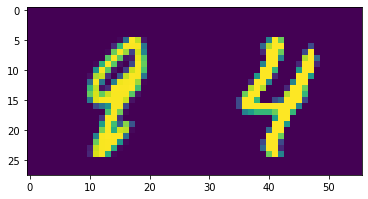

In [ ]:
    im = np.zeros((28,56))
    tens_index = rd.randint(0,len(ans_train)-1)   
    ones_index = rd.randint(0,len(ans_train)-1) 
    for i in range(28):
        im[:,i] = imgs_train[tens_index,:,i]
        im[:,i+28] = imgs_train[ones_index,:,i]
    answer = ans_train[tens_index]*10 + ans_train[ones_index]
    print ("Answer =", ans_train[tens_index],"* 10 +",ans_train[ones_index],"=",answer)
    plt.imshow(im)

0 ...
~Random example~
Answer: 52


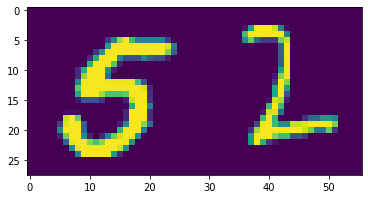

In [ ]:
def doubleDigits(images=imgs_train,answers=ans_train):
    im = np.zeros((28,56))
    tens_index = rd.randint(0,len(answers)-1)  # HERE IS WHERE THE 
    ones_index = rd.randint(0,len(answers)-1)             # RANDOM NUMS COME FROM
    for i in range(28):
        im[:,i] = images[tens_index,:,i]
        im[:,i+28] = images[ones_index,:,i]
    answer = answers[tens_index]*10 + answers[ones_index] #CALCULATE THE RIGHT
    return im, answer                         #ANSWER NUMERICALLY                
    #returns image array, list of answers
print("Loaded function doubleDigits.")

# THIS FUNCTION WILL BE CALLED TO GENERATE A NEW 
# TRAINING SET OF RANDOM DOUBLE-DIGIT IMAGES TO WORK WITH

def getDoubleDigits(x_df=imgs_train,y_df=ans_train,how_many=1):
    '''
        Get a trainable set of how_many double-digit images. 
        Returns two objects:
            - xdf, an array with how_many 28x56 images (ie. of shape(how_many,28,56)),
            - ydf, a 1D array with the corresponding labels (shape(how_many,1))
    '''
    yy = []
    xx = []
    for i in range(how_many):
        dd, ans = doubleDigits(x_df,y_df)
        yy += [ans]
        xx.append(dd)
        if i%1000 == 0:
            clear()
            print(i,"...")
    return xx, yy

print("Loaded function getDoubleDigits.")

# AND FINALLY CALL FUNCTION gDD TO SHOW AN EXAMPLE OF A 
# CONSTRUCTED IMAGE AND ANSWER TO MAKE SURE IT LOOKS OK
xdf, ydf = getDoubleDigits(imgs_test,ans_test)
print('~Random example~')
print('Answer:',ydf[0])
plt.imshow(xdf[0])

In [ ]:
xts, yts = getDoubleDigits(imgs_test,ans_test,4000)
x_test = np.array(xts) / 255.
y_test = np.array(yts)
print("Made",4000,"new double-digit images to test on.")

xtn, ytn = getDoubleDigits(imgs_train,ans_train,40000)
x_train = np.array(xtn) / 255.
y_train = np.array(ytn)
print("Made",40000,"new double-digit images to train on.")

39000 ...
Made 40000 new double-digit images to train on.


In [ ]:
# Add a channels dimension
x_train = x_train[..., tf.newaxis].astype("float32")
x_test = x_test[..., tf.newaxis].astype("float32")

## Building a Minimalist Convnet

In [ ]:
###################### Stack Model Layers
##########################################
def stack_new_model():
    input_layer = layers.Input(shape=(28, 56, 1))
    x = layers.Conv2D(4, 6, activation='relu')(input_layer)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(3, 3, activation='relu', strides=(2))(x) 
    x = layers.Conv2D(1, 3, activation='relu', strides=(2))(x) 
    #x = layers.Conv2D(1, 2, activation='relu', strides=(1))(x) 
    #x = layers.MaxPooling2D(2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(12, activation='relu')(x)  ### how few ?! ####
    x = layers.Dropout(0.1)(x)
    output_layer = layers.Dense(100)(x)#, activation='softmax')(x)
    model = Model(input_layer, output_layer)
    ############################## Compile
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                                                            optimizer=Adam(lr=0.0075),
                                                            metrics=['acc'])
    return model, ([], [], [], []) # new set each new _compile_

In [ ]:
####################### TF Datasets for input

train_ds = tf.data.Dataset.from_tensor_slices( (x_train, y_train) )
test_ds = tf.data.Dataset.from_tensor_slices( (x_test, y_test) )

###################### Stack Layers
input_layer = layers.Input(shape=(28, 56, 1))
x = layers.Conv2D(2, (3,4), activation='relu')(input_layer)
x = layers.MaxPooling2D(2)(x)
#x = layers.Conv2D(3, (2,3), activation='relu')(x) 
#x = layers.MaxPooling2D(2)(x)
#x = layers.Conv2D(5, (2,3), activation='relu')(x) # ,strides=(2))(x) 
x = layers.Flatten()(x)
#x = layers.Dense(10, activation='relu')(x) 
x = layers.Dropout(0.25)(x)
output_layer = layers.Dense(100)(x)#, activation='softmax')(x)

####################### Build
model = Model(input_layer, output_layer)

####################### Compile
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                optimizer=Adam(lr=0.0075),
                metrics=['acc'])
####################### Layer-outputs model
layer_outputs = [layer.output for layer in model.layers[1:]]
output_model = Model(input_layer, layer_outputs)

####################### History containers
answers, guesses = [],[]#, max_guesses, flatout = [],[],[],np.zeros((N,4))

In [ ]:
model.summary()

Model: "functional_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 28, 56, 1)]       0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 26, 53, 2)         26        
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 13, 26, 2)         0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 676)               0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 676)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 100)               67700     
Total params: 67,726
Trainable params: 67,726
Non-trainable params: 0
_________________________________________________

### Training / Loading and reloading

In [ ]:
############################# Train
mhistory = model.fit(train_ds.shuffle(40001).batch(40), 
                        epochs=15,  
                        validation_data=test_ds.batch(100), 
                        verbose=1)

In [ ]:
################ Save / Load weights and ckpts
###model.load_weights('VCD_weights/VCD_weights')
###model.save_weights('VCD_weights/VCD_weights')

In [ ]:
#@title Defunct
def mg():
    layer_outputs = [layer.output for layer in model.layers[1:]]
    output_model = Model(input_layer, layer_outputs)

    # Take random image from the training set.
    take1_ds = test_ds.shuffle(10001).take(1)
    for img, ans in take1_ds:
        answer = ans.numpy()
        img = img.numpy()                  # np shape (28, 28, 1)
    img = img.reshape((1,) + img.shape)    # np shape (1, 28, 28, 1)
    guess_set = model.predict(img)
    guess = tf.random.categorical( guess_set, num_samples=1 ).numpy().squeeze()

    answers += [answer]
    guesses += [guess]
    print ("Answer:",answer, "\tGuess:", guess,)
    #plt.imshow( img[0,:,:,0] )

    layer_output_maps = output_model.predict( img )
    layer_names = [layer.name for layer in model.layers[1:]]
    for layer_name, layer_map in zip(layer_names, layer_output_maps):
        if len(layer_map.shape) == 4 and not 'max_pooling' in layer_name:
            n_maps = layer_map.shape[-1]  # number of maps
            # Map has shape (1, size, size, n_features)
            rows = layer_map.shape[1]
            cols = layer_map.shape[2]
            image_grid = np.zeros((rows, cols * n_maps))
            for i in range(n_maps):
                x = layer_map[0, :, :, i]
                x *= 255.0
                image_grid[:, i * rows : (i + 1) * cols] = x
        
            # Display the grid
            scale = 2.           
            plt.figure(figsize=(scale * n_maps, scale))
            plt.title(layer_name)
            plt.grid(False)
            plt.imshow(image_grid, aspect='auto', cmap='viridis')
        else:
            if 'flatten' in layer_name:   
                print("Out from flatten:", np.round(layer_map.squeeze(),2))
                flatout += [layer_map.squeeze()]

### Visualizing Intermediate Representations


In [ ]:
#@title Function GUESSING()
def guessing(N=1):
    answers, guesses = [],[]
    print ('Processing...\n')
    for count in range(N):
        take1_ds = test_ds.shuffle(10001).take(1)
        for img, ans in take1_ds:
            answer = ans.numpy()
            img = img.numpy()                  # 28x56x1
        img = img.reshape((1,) + img.shape)    # 1x28x56x1
        guess_set = model.predict(img)
        guess = tf.random.categorical( guess_set, num_samples=1 ).numpy().squeeze()

        answers += [answer]
        guesses += [guess]
        #pG += [guess_set[guess]]
        #pA += [guess_set[answer]]
        #print("Answer",answer,"\tGuess",guess)#, "\tp(A)",pA,"\tp(G)",pG)
       
        if count%20 == 0:
            print ('Processing...',count,"...")
            clear_output(wait=True)

    return answers, guesses#, pA, pG

In [ ]:
#@title Define fxn showOutput()
def showOutput(img, model=output_model):
    plt.imshow(img[:,:,0])
    layer_output_maps = model.predict( img )
    layer_names = [layer.name for layer in model.layers[1:]]
    for layer_name, layer_map in zip(layer_names, layer_output_maps):
        if len(layer_map.shape) == 4 and not 'max_pooling' in layer_name:
            n_maps = layer_map.shape[3] 
            # Map has shape (1, size, size, n_maps)
            rows = layer_map.shape[1]
            cols = layer_map.shape[2]
            image_grid = np.zeros((rows, cols * n_maps))
            for i in range(n_maps):
                x = layer_map[0, :, :, i]
                x *= 255.0
                image_grid[:, i * cols : (i + 1) * cols] = x
                image_grid[:,i*cols] = 255
                image_grid[:,i*cols+1] = 128
            scale = 2.           
            plt.figure(figsize=(scale * n_maps, scale))
            plt.title(layer_name)
            plt.grid(False)
            plt.imshow(image_grid, aspect='auto', cmap='viridis')

In [ ]:
#@title Function GET_RESULTS()
def get_results(N):
    results = pd.DataFrame(columns=['Answer','Guess'])#,'P(A)','P(G)'])
    results['Answer'], results['Guess'] = guessing(N) #, results['P(A)'], results['P(G)'] 
    return results

In [ ]:
results = get_results(100)
results

,Answer,Guess
0,35,35
1,41,41
2,51,51
3,50,50
4,25,25
...,...,...
95,61,61
96,77,77
97,92,90
98,66,66


In [ ]:
#showOutput()

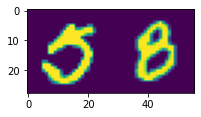

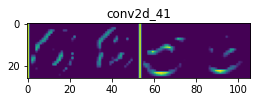

In [ ]:
#@title Show layer output...

# Take random image from the training set.
take1_ds = test_ds.shuffle(10001).take(1)
for img, ans in take1_ds:
    img = img.numpy() 
plt.figure(figsize=(3,3))
plt.imshow(img[:,:,0])                 # np shape (28, 28, 1)
img = img.reshape((1,) + img.shape)    # np shape (1, 28, 28, 1)

layer_output_maps = output_model.predict( img )
layer_names = [layer.name for layer in model.layers[1:]]
for layer_name, layer_map in zip(layer_names, layer_output_maps):
    if len(layer_map.shape) == 4 and not 'max_pooling' in layer_name:
        n_maps = layer_map.shape[-1]  # number of maps
        # Map has shape (1, rows, columns, n_features)
        rows = layer_map.shape[1]
        cols = layer_map.shape[2]
        image_grid = np.zeros((rows, cols * n_maps))
        
        for i in range(n_maps):
            x = layer_map[0, :, :, i]
            x *= 255.0
            image_grid[:, i * cols : (i + 1) * cols] = x
            image_grid[:,i*cols] = 255.
            image_grid[:,i*cols+1] = 0.
            
        scale = 2.           
        plt.figure(figsize=(scale * n_maps, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(image_grid, cmap='viridis')
 

In [ ]:
n = 10
for i, c in enumerate(['Answer','Guess']):
    x = list(range(i,n+i))
    x = [(xx + i*0.05) for xx in x]
    y = results[c][:n]
    plt.bar(x, y)

### Get answers and compare with predictions.

In [ ]:
tv = results['Guess'] == results['Answer']
wrongs = results.loc[~tv]
wrongs

,Answer,Guess
10,22,28
13,97,37
19,2,8
21,8,2
34,18,17
42,92,72
45,22,12
47,9,69
58,33,53
59,21,31


In [ ]:
## Display some examples of *wrong* guesses
###########################################
#index = rd.choice(wrongs.index)  
#a = wrongs.at[index,'Answer']
#print("Answer[",index,"] is", a)
#print("Guess[",index,"] was",wrongs.at[index,'Guess'])
#plt.imshow(x_test[a,:,:,0])

### Evaluation

Text(0.5, 1.0, 'Training and validation loss')

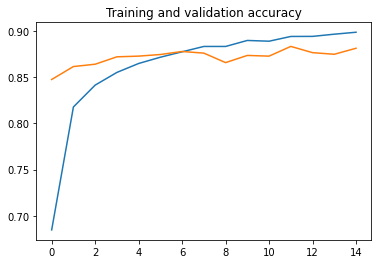

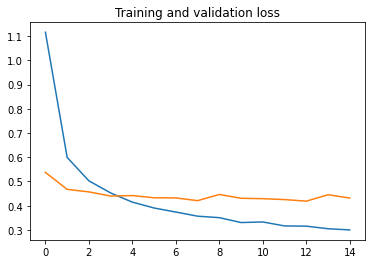

In [ ]:
#@title Display learning curves ##TO DO##

####TO DO make better #########

acc = mhistory.history['acc']
val_acc = mhistory.history['val_acc']

loss = mhistory.history['loss']
val_loss = mhistory.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')